## Summary

The toppic of this project is Kaggle competition:
[Facial Keypoints Detection](https://www.kaggle.com/competitions/facial-keypoints-detection/overview)

The idea is to create an algorithm that predicts the locations of keypoints in unlabeled images.\
Performance is evaluated on the Kaggle test dataset, where keypoint locations are not publicly available. Predicted keypoints are sent as a CSV file and scored based on root mean square error. \
The solution can also be tested on a self-created set of images to visually verify that it can accurately locate keypoints.

Detecting facial keypoint is a challenging problem. Facial features vary from one individual to another. Another diffiulty is caused by image variations, such as image size, 3D pose, imumination etc.
Succcesfull facial keypoint detection serves as a base for many practical applications, such as:
- tracking faces in video
- biometrics
- analysing facial expression
- detectiog dysmorphic facial signs for medical diagnosis

__Objective:__
- Predict keypoint positions on face images

__Problem:__
- Supervised learning
- Regression
- Root Mean Squared Metrics - evaluation metrics

__Data:__
- CSV format
- Features - Face images 
- Labels - 15 keypoints to detect
- 7049 trainin examples, 1783 test images, 27124 keypoints to predict

__Solving approach:__
- Train Convolutional Neural Network to detect facial keypoints
- Tensorflow framework


## Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from math import sin, cos, pi

import cv2

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import callbacks
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPool2D, BatchNormalization
from tensorflow.keras.metrics import RootMeanSquaredError
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint

from sklearn.model_selection import train_test_split

## Hyperparameter Settings

In [2]:
# Include data with missing values in training
include_missing_values = True 

# Augmentation parameters
horizontal_flip = False
rotation_augmentation = True
brightness_augmentation = True
shift_augmentation = True
random_noise_augmentation = True
rotation_angles = [12] # Rotation angle in degrees 
pixel_shifts = [12] # Horizontal and vertical shifts
sample_image_index = 20 # Train sample used as visualizing example

# Neural Network parameters
NUM_EPOCHS = 50
BATCH_SIZE = 32

## Raw Data

There are two CSV files with images:
- __training.cvs__ - Training images and keypoint locations
- __test.csv__ - Test images

Two additional CSVs serve as guidelines for creating the submission file
(_Note: Not all 15 features have to be predicted for every test image_).
- __IdLookupTable.csv__ - Features to predict for each test image.
- __Sample submission.csv__ - Sample of formated submission file

In [3]:
train_df = pd.read_csv('training.csv')
test_df = pd.read_csv('test.csv')

id_lookup = pd.read_csv('IdLookupTable.csv')
sample_submission = pd.read_csv('SampleSubmission.csv')

In [4]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7049 entries, 0 to 7048
Data columns (total 31 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   left_eye_center_x          7039 non-null   float64
 1   left_eye_center_y          7039 non-null   float64
 2   right_eye_center_x         7036 non-null   float64
 3   right_eye_center_y         7036 non-null   float64
 4   left_eye_inner_corner_x    2271 non-null   float64
 5   left_eye_inner_corner_y    2271 non-null   float64
 6   left_eye_outer_corner_x    2267 non-null   float64
 7   left_eye_outer_corner_y    2267 non-null   float64
 8   right_eye_inner_corner_x   2268 non-null   float64
 9   right_eye_inner_corner_y   2268 non-null   float64
 10  right_eye_outer_corner_x   2268 non-null   float64
 11  right_eye_outer_corner_y   2268 non-null   float64
 12  left_eyebrow_inner_end_x   2270 non-null   float64
 13  left_eyebrow_inner_end_y   2270 non-null   float

In [5]:
train_df.head().T

0  \
left_eye_center_x                                                  66.033564   
left_eye_center_y                                                  39.002274   
right_eye_center_x                                                 30.227008   
right_eye_center_y                                                 36.421678   
left_eye_inner_corner_x                                            59.582075   
left_eye_inner_corner_y                                            39.647423   
left_eye_outer_corner_x                                            73.130346   
left_eye_outer_corner_y                                            39.969997   
right_eye_inner_corner_x                                           36.356571   
right_eye_inner_corner_y                                           37.389402   
right_eye_outer_corner_x                                           23.452872   
right_eye_outer_corner_y                                           37.389402   
left_eyebrow_inner_end_x                                           56.953263   
left_eyebrow_inner_end_y                                           29.033648   
left_eyebrow_outer_end_x                                           80.227128   
left_eyebrow_outer_end_y                                           32.228138   
right_eyebrow_inner_end_x                                          40.227609   
right_eyebrow_inner_end_y                                          29.002322   
right_eyebrow_outer_end_x                                          16.356379   
right_eyebrow_outer_end_y                                          29.647471   
nose_tip_x                                                         44.420571   
nose_tip_y                                                         57.066803   
mouth_left_corner_x                                                61.195308   
mouth_left_corner_y                                                79.970165   
mouth_right_corner_x                                               28.614496   
mouth_right_corner_y                                               77.388992   
mouth_center_top_lip_x                                             43.312602   
mouth_center_top_lip_y                                             72.935459   
mouth_center_bottom_lip_x                                          43.130707   
mouth_center_bottom_lip_y                                          84.485774   
Image                      238 236 237 238 240 240 239 241 241 243 240 23...   

                                                                           1  \
left_eye_center_x                                                  64.332936   
left_eye_center_y                                                  34.970077   
right_eye_center_x                                                 29.949277   
right_eye_center_y                                                 33.448715   
left_eye_inner_corner_x                                             58.85617   
left_eye_inner_corner_y                                            35.274349   
left_eye_outer_corner_x                                            70.722723   
left_eye_outer_corner_y                                            36.187166   
right_eye_inner_corner_x                                           36.034723   
right_eye_inner_corner_y                                           34.361532   
right_eye_outer_corner_x                                           24.472511   
right_eye_outer_corner_y                                           33.144443   
left_eyebrow_inner_end_x                                           53.987404   
left_eyebrow_inner_end_y                                           28.275949   
left_eyebrow_outer_end_x                                           78.634213   
left_eyebrow_outer_end_y                                           30.405923   
right_eyebrow_inner_end_x                                          42.728851   
right_eyebrow_inner_end_y                                          26.1460

In [6]:
test_df.head()

ImageId                                              Image
0        1  182 183 182 182 180 180 176 169 156 137 124 10...
1        2  76 87 81 72 65 59 64 76 69 42 31 38 49 58 58 4...
2        3  177 176 174 170 169 169 168 166 166 166 161 14...
3        4  176 174 174 175 174 174 176 176 175 171 165 15...
4        5  50 47 44 101 144 149 120 58 48 42 35 35 37 39 ...

In [7]:
train_df_clean = train_df.dropna()
train_df_clean.shape

(2140, 31)

## Data Transformation

### Features - X_train
The only feature is "Image" column.  Image format is 96x96 pixels with one colour channel. Values are given as a string and need to be transformed into a matrix of 96x96x1 format, for an image size 96x96 pixels with one colour channel.

### Labels - y_train
Each of 15 labels (facial keypoints) is representend by two columns, x-axis  and y-axis coordinates. 

__Keypoints to detect:__\
left eye center, right eye center, left eye inner corner, left eye outer corner, right eye inner corner, right eye outer corner, left eyebrow inner end, left eyebrow outer end, right eyebrow inner end, right eyebrow outer end, nose tip, mouth left corner, mouth right corner, mouth center top lip, mouth center bottom lip

In [8]:
m_train, n_train = train_df.shape
m_clean, n_clean = train_df_clean.shape
m_test, n_test = test_df.shape
img_height, img_width = 96, 96

In [9]:
# Iterate over all the rows and split the individual entries of Image column
# If there are any blank spaces i.e. null values in the pixels, replace it with 0
def transform_features(df, df_range):
    X_data = []
    for idx, sample in df.iterrows():
        face_pixel = np.array(sample['Image'].split(' '), dtype='float')
        face_pixel = np.reshape(face_pixel, (img_height,img_width,1))
        # Normalize pixel values 
        face_pixel /=255
        X_data.append(face_pixel)
    X_data = np.array(X_data)
    return X_data

X_train = transform_features(train_df,m_train)
X_test = transform_features(test_df, m_test)

In [10]:
y_train = train_df.drop(labels=['Image'], axis=1)
y_train.isnull().sum()

left_eye_center_x              10
left_eye_center_y              10
right_eye_center_x             13
right_eye_center_y             13
left_eye_inner_corner_x      4778
left_eye_inner_corner_y      4778
left_eye_outer_corner_x      4782
left_eye_outer_corner_y      4782
right_eye_inner_corner_x     4781
right_eye_inner_corner_y     4781
right_eye_outer_corner_x     4781
right_eye_outer_corner_y     4781
left_eyebrow_inner_end_x     4779
left_eyebrow_inner_end_y     4779
left_eyebrow_outer_end_x     4824
left_eyebrow_outer_end_y     4824
right_eyebrow_inner_end_x    4779
right_eyebrow_inner_end_y    4779
right_eyebrow_outer_end_x    4813
right_eyebrow_outer_end_y    4813
nose_tip_x                      0
nose_tip_y                      0
mouth_left_corner_x          4780
mouth_left_corner_y          4780
mouth_right_corner_x         4779
mouth_right_corner_y         4779
mouth_center_top_lip_x       4774
mouth_center_top_lip_y       4774
mouth_center_bottom_lip_x      33
mouth_center_b

### Missing Values


Many keypoints are missing values. There are several options to deal with it. 

A direct approach would be to delete rows with missing data, but this would significantly reduce the training set and affect the predictions.

Another option is to fill the missing values. They will be replaced with previous values in that raw, using _ffill_ method.\
Replacing missing values with mean doesn't guarrenty that the newly filled positions will be aaccurately alligned with the atributes. 

In [11]:
y_train.fillna(method='ffill', inplace=True)

def transform_labels(df):
    train_targets = []
    for i in range(len(df)):
        y = df.iloc[i,:].values
        train_targets.append(y)
    df = train_targets
    df = np.array(df, dtype = 'float')
    return df

y_train = transform_labels(y_train)

## Plot Samples

#### Train and Test samples

In [12]:
def plot_samples(dataset, title):
    fig = plt.figure(figsize = (12,3))
    fig.suptitle(title, fontsize=15)
    for i in range(4):
        fig.add_subplot(1,4,i+1, xticks=[], yticks=[])
        plt.imshow(dataset[i])
    plt.show()

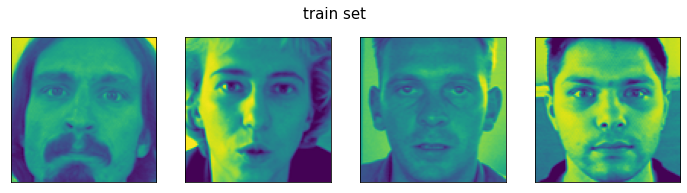

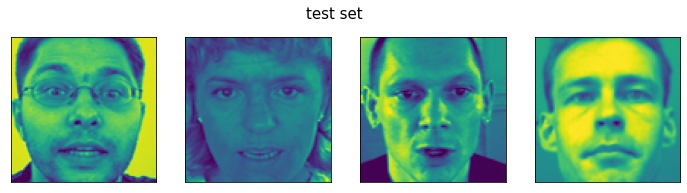

In [13]:
plot_samples(X_train, 'train set')
plot_samples(X_test, 'test set')

#### Train samples with keypoints

In [14]:
def plot_keypoints(X_train, y_train, index):
    image =  plt.imshow(X_train[index])
    feature = []
    for i in range(1, 31, 2):
        feature.append(plt.plot(y_train[index][i-1], y_train[index][i], 'ro'))
    return image, feature

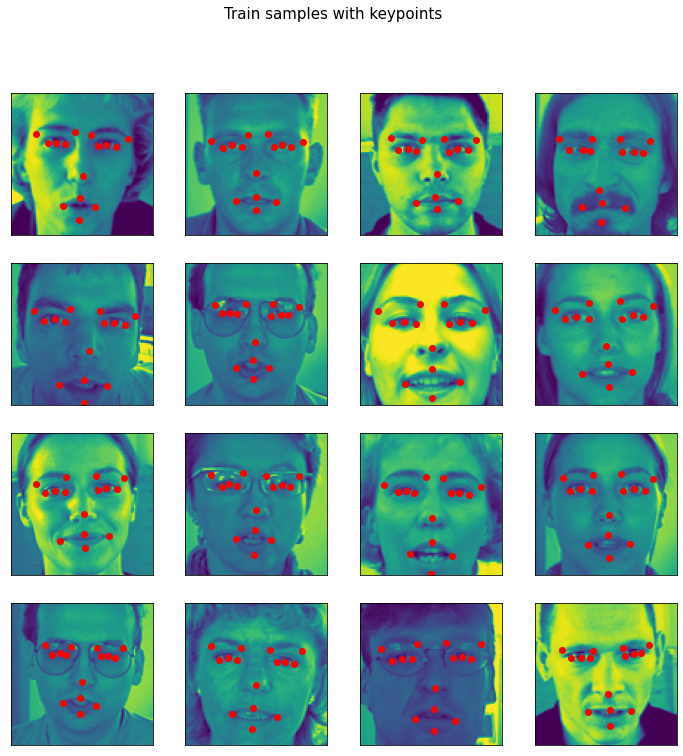

In [15]:
fig = plt.figure(figsize = (12,12))
fig.suptitle('Train samples with keypoints', fontsize=15)

for j in range (16):
    fig.add_subplot(4,4,j+1, xticks=[], yticks=[])
    plot_keypoints(X_train, y_train, j+1)
plt.show()

## Data Augmentation

Images from the training set will be transformed in several ways to obtain new examples useful for the neural network.\
Transformations will be performed only on images that initially didn't have any null keypoint values.


In [16]:
X_train_clean = transform_features(train_df_clean, m_clean)

y_train_clean = train_df_clean.drop(labels=['Image'], axis=1)
y_train_clean = transform_labels(y_train_clean)

In [17]:
print('Shape of training images avaliable for augmentation{}'.format(X_train_clean.shape))
print(y_train_clean.shape)

Shape of training images avaliable for augmentation(2140, 96, 96, 1)
(2140, 30)


#### Performe Horizontal Flip

Horizontal inversion will not be performed, because it does not represent a new scenario for training neural networks.

In [18]:
def left_right_flip(images, keypoints):
    flipped_keypoints = []
    flipped_images = np.flip(images, axis=2)   # Flip column-wise (axis=2)
    for idx, sample_keypoints in enumerate(keypoints):
        flipped_keypoints.append([96.-coor if idx%2==0 else coor for idx,coor in enumerate(sample_keypoints)])    # Subtract only X co-ordinates of keypoints from 96 for horizontal flipping
    return flipped_images, flipped_keypoints

if horizontal_flip:
    flipped_train_images, flipped_train_keypoints = left_right_flip(X_train_clean, y_train_clean)
    X_train = np.concatenate((X_train, flipped_train_images))
    y_train = np.concatenate((y_train, flipped_train_keypoints))
    

#### Performe Rotation

Keypoints rotation:
[How to rotate a set of points by a certain angle](https://in.mathworks.com/matlabcentral/answers/93554-how-can-i-rotate-a-set-of-points-in-a-plane-by-a-certain-angle-about-an-arbitrary-point)


Augmenting for angles (in degrees): 
12  -12  

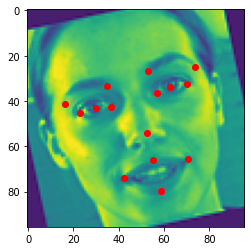

In [19]:
def rotate_augmentation(images, keypoints):
    rotated_images = []
    rotated_keypoints = []
    print("Augmenting for angles (in degrees): ")
    for angle in rotation_angles:    # Rotation augmentation for a list of angle values
        for angle in [angle,-angle]:
            print(f'{angle}', end='  ')
            M = cv2.getRotationMatrix2D((48,48), angle, 1.0)
            angle_rad = -angle*pi/180.     # Obtain angle in radians from angle in degrees (notice negative sign for change in clockwise vs anti-clockwise directions from conventional rotation to cv2's image rotation)
            # For train_images
            for image in images:
                rotated_image = cv2.warpAffine(image, M, (96,96), flags=cv2.INTER_CUBIC)
                rotated_images.append(rotated_image)
            # For train_keypoints
            for keypoint in keypoints:
                rotated_keypoint = keypoint - 48.    # Subtract the middle value of the image dimension
                for idx in range(0,len(rotated_keypoint),2):
                    rotated_keypoint[idx] = rotated_keypoint[idx]*cos(angle_rad)-rotated_keypoint[idx+1]*sin(angle_rad)
                    rotated_keypoint[idx+1] = rotated_keypoint[idx]*sin(angle_rad)+rotated_keypoint[idx+1]*cos(angle_rad)
                rotated_keypoint += 48.   # Add the earlier subtracted value
                rotated_keypoints.append(rotated_keypoint)
            
    return np.reshape(rotated_images,(-1,96,96,1)), rotated_keypoints
     
if rotation_augmentation:
    rotated_train_images, rotated_train_keypoints =  rotate_augmentation(X_train_clean, y_train_clean)
    X_train = np.concatenate((X_train, rotated_train_images))
    y_train = np.concatenate((y_train, rotated_train_keypoints))
    fig, axis = plt.subplots()
    plot_keypoints(rotated_train_images, rotated_train_keypoints, sample_image_index)    

#### Brightness Alteration

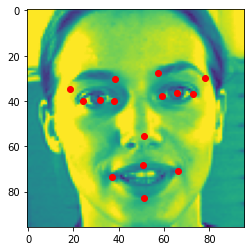

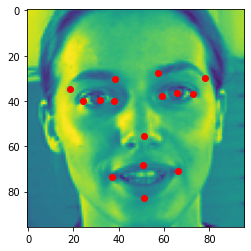

In [20]:
def alter_brightness(images, keypoints):
    bright_images = []
    # Increase brightness and clip values outside of the range
    increased_brightness_images = np.clip(images*1.2, 0.0, 1.0) 
    # Decrease brightness and clip values outside of the range
    decreased_brightness_images = np.clip(images*0.7, 0.0, 1.0)
    
    bright_images.extend(increased_brightness_images)
    bright_images.extend(decreased_brightness_images)
    
    return bright_images, np.concatenate((keypoints, keypoints))

if brightness_augmentation:
    altered_brightness_images, altered_brightness_keypoints = alter_brightness(X_train_clean, y_train_clean)
    X_train = np.concatenate((X_train, altered_brightness_images))
    y_train = np.concatenate((y_train, altered_brightness_keypoints))
    plot_keypoints(altered_brightness_images, altered_brightness_keypoints, sample_image_index)
    plt.show()
    plot_keypoints(altered_brightness_images, altered_brightness_keypoints, len(altered_brightness_images)//2+sample_image_index)                                         
    plt.show()

#### Horizontal and Vertical shift

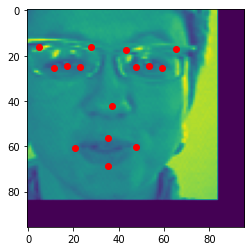

In [21]:
def shift_images(images, keypoints):
    shifted_images = []
    shifted_keypoints = []
    for shift in pixel_shifts:    # Augmenting over several pixel shift values
        for (shift_x,shift_y) in [(-shift,-shift),(-shift,shift),(shift,-shift),(shift,shift)]:
            M = np.float32([[1,0,shift_x],[0,1,shift_y]])
            for image, keypoint in zip(images, keypoints):
                shifted_image = cv2.warpAffine(image, M, (96,96), flags=cv2.INTER_CUBIC)
                shifted_keypoint = np.array([(point+shift_x) if idx%2==0 else (point+shift_y) for idx, point in enumerate(keypoint)])
                if np.all(0.0<shifted_keypoint) and np.all(shifted_keypoint<96.0):
                    shifted_images.append(shifted_image.reshape(96,96,1))
                    shifted_keypoints.append(shifted_keypoint)
    shifted_keypoints = np.clip(shifted_keypoints,0.0,96.0)
    return shifted_images, shifted_keypoints

if shift_augmentation:
    shifted_train_images, shifted_train_keypoints = shift_images(X_train_clean, y_train_clean)
    X_train = np.concatenate((X_train, shifted_train_images))
    y_train = np.concatenate((y_train, shifted_train_keypoints))
    plot_keypoints(shifted_train_images, shifted_train_keypoints, sample_image_index*3)
    plt.show()

#### Random Noise

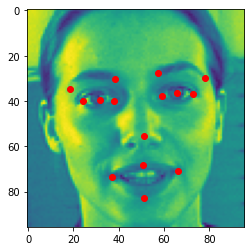

In [22]:
def add_noise(images):
    noisy_images = []
    for image in images:
        noisy_image = cv2.add(image, 0.008*np.random.randn(96,96,1))
        noisy_images.append(noisy_image.reshape(96,96,1))
    return noisy_images

if random_noise_augmentation:
    noisy_train_images = add_noise(X_train_clean)
    X_train = np.concatenate((X_train, noisy_train_images))
    y_train = np.concatenate((y_train, y_train_clean))
    plot_keypoints(noisy_train_images, y_train_clean, sample_image_index)
    plt.show()

#### Training parameters overview

In [23]:
print("Final shape of train images: {}".format(X_train.shape))
print("Final shape of train keypoints: {}".format(y_train.shape))

Final shape of train images: (24099, 96, 96, 1)
Final shape of train keypoints: (24099, 30)


## Building a Model

__Model:__
- Sequential model
- Input shape 96x96x1 represents 96x96 pixels of image and 1 colour channel
- Three Convolutional blocks 
- Two Dense blocks

__Compiler:__
- Adam optimizer
- Root Mean Squared Error, accuracy
- Mean Absolute Error loss

__Checkpointer:__
- monitor val_root_mean_square_error

In [24]:

model = Sequential([
    layers.Conv2D(32, (3,3), activation='relu', input_shape=(96,96,1)),
    layers.MaxPool2D((2,2)),
    layers.BatchNormalization(),
    layers.Conv2D(128, (5,5), activation='relu'),
    layers.MaxPool2D((2,2)),
    layers.Dropout(0.4),
    layers.BatchNormalization(),
    layers.Conv2D(256, (3,3), activation='relu'),
    layers.MaxPool2D((2,2)),
    layers.Dropout(0.4),
    layers.BatchNormalization(),
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.1),
    layers.Dense(30, activation='relu')
])

model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 94, 94, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 47, 47, 32)       0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 47, 47, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 43, 43, 128)       102528    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 21, 21, 128)      0         
 2D)                                                             
                                                        

In [25]:

checkpointer = ModelCheckpoint(filepath = 'best_model.hdf5', monitor='val_root_mean_squared_error', verbose=1, save_best_only=True, mode='min')
model.compile(optimizer='Adam', 
              metrics=[RootMeanSquaredError(name='root_mean_squared_error'), 'accuracy'], 
              loss='mae')


In [26]:

history = model.fit(X_train, 
                    y_train, 
                    epochs =NUM_EPOCHS, 
                    batch_size=BATCH_SIZE, 
                    validation_split=0.05,
                    callbacks=[checkpointer])


Epoch 1/50
716/716 [==============================] - ETA: 0s - loss: 6.0114 - root_mean_squared_error: 9.1540 - accuracy: 0.4936
Epoch 1: val_root_mean_squared_error improved from inf to 11.00339, saving model to best_model.hdf5
716/716 [==============================] - 436s 607ms/step - loss: 6.0114 - root_mean_squared_error: 9.1540 - accuracy: 0.4936 - val_loss: 9.9793 - val_root_mean_squared_error: 11.0034 - val_accuracy: 0.5900
Epoch 2/50
716/716 [==============================] - ETA: 0s - loss: 3.8946 - root_mean_squared_error: 5.2293 - accuracy: 0.6169
Epoch 2: val_root_mean_squared_error improved from 11.00339 to 3.03453, saving model to best_model.hdf5
716/716 [==============================] - 416s 581ms/step - loss: 3.8946 - root_mean_squared_error: 5.2293 - accuracy: 0.6169 - val_loss: 2.1916 - val_root_mean_squared_error: 3.0345 - val_accuracy: 0.6373
Epoch 3/50
716/716 [==============================] - ETA: 0s - loss: 3.2238 - root_mean_squared_error: 4.3466 - accuracy

Epoch 21/50
716/716 [==============================] - ETA: 0s - loss: 2.3094 - root_mean_squared_error: 3.1345 - accuracy: 0.7703
Epoch 21: val_root_mean_squared_error did not improve from 2.13186
716/716 [==============================] - 19769s 28s/step - loss: 2.3094 - root_mean_squared_error: 3.1345 - accuracy: 0.7703 - val_loss: 1.6231 - val_root_mean_squared_error: 2.2642 - val_accuracy: 0.7178
Epoch 22/50
716/716 [==============================] - ETA: 0s - loss: 2.3183 - root_mean_squared_error: 3.1399 - accuracy: 0.7724
Epoch 22: val_root_mean_squared_error did not improve from 2.13186
716/716 [==============================] - 389s 544ms/step - loss: 2.3183 - root_mean_squared_error: 3.1399 - accuracy: 0.7724 - val_loss: 1.6899 - val_root_mean_squared_error: 2.3120 - val_accuracy: 0.7178
Epoch 23/50
716/716 [==============================] - ETA: 0s - loss: 2.3070 - root_mean_squared_error: 3.1227 - accuracy: 0.7757
Epoch 23: val_root_mean_squared_error did not improve from 

716/716 [==============================] - ETA: 0s - loss: 2.1219 - root_mean_squared_error: 2.8803 - accuracy: 0.7880
Epoch 41: val_root_mean_squared_error did not improve from 1.92717
716/716 [==============================] - 395s 552ms/step - loss: 2.1219 - root_mean_squared_error: 2.8803 - accuracy: 0.7880 - val_loss: 2.0692 - val_root_mean_squared_error: 2.6328 - val_accuracy: 0.7212
Epoch 42/50
716/716 [==============================] - ETA: 0s - loss: 2.1191 - root_mean_squared_error: 2.8678 - accuracy: 0.7872
Epoch 42: val_root_mean_squared_error improved from 1.92717 to 1.89654, saving model to best_model.hdf5
716/716 [==============================] - 394s 550ms/step - loss: 2.1191 - root_mean_squared_error: 2.8678 - accuracy: 0.7872 - val_loss: 1.3538 - val_root_mean_squared_error: 1.8965 - val_accuracy: 0.7278
Epoch 43/50
716/716 [==============================] - ETA: 0s - loss: 2.1203 - root_mean_squared_error: 2.8708 - accuracy: 0.7908
Epoch 43: val_root_mean_squared_er

In [27]:
model.save('mymodel')

INFO:tensorflow:Assets written to: mymodel\assets


INFO:tensorflow:Assets written to: mymodel\assets


In [28]:
#from tensorflow import keras
#model = keras.models.load_model('mymodel')
#predict = model.predict(test_images)

## Model Performance

In [29]:
print(history.history.keys())

dict_keys(['loss', 'root_mean_squared_error', 'accuracy', 'val_loss', 'val_root_mean_squared_error', 'val_accuracy'])


In [30]:

def plot_loss(hist, feature, plt):
    loss = hist[feature]
    val_loss = hist['val_'+feature]
    plt.plot(loss,'--', label = 'train')
    plt.plot(val_loss, label = 'val')
    plt.title(feature+' per epoch')
    plt.legend()
    plt.grid()
    plt.xlabel('epoch')
    plt.show()


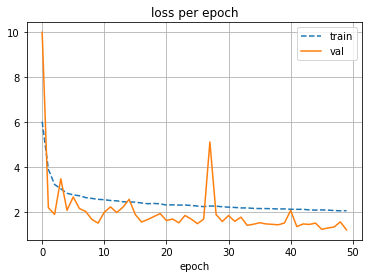

In [31]:
plot_loss(history.history, 'loss', plt)

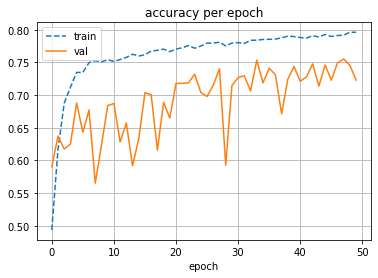

In [32]:
plot_loss(history.history, 'accuracy', plt)

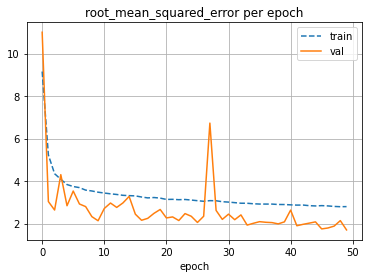

In [33]:
plot_loss(history.history, 'root_mean_squared_error', plt)

### _Note:_
_By adding more layers and features, or increasing certain parameters, such as the number of epochs, the performance of the model can be further improved. The downside is time required for training. Since this model is trained on a private computer with limited performance, some parameters are lowered to speed up the training._

## Test Set Predictions

Predict keypoint locations for test set, and create submission file for the competition.

In [35]:
predict = model.predict(X_test)

56/56 [==============================] - 7s 117ms/step


#### Vizualize test predictions

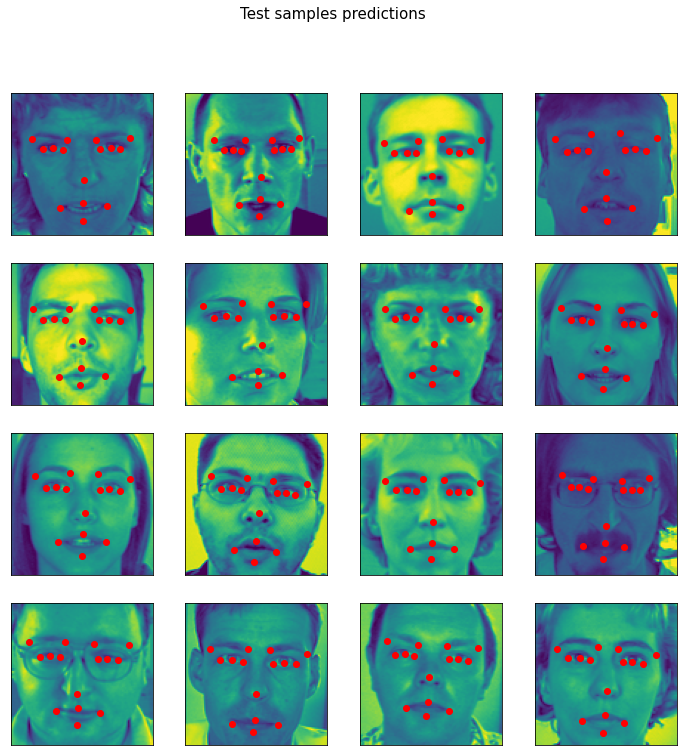

In [36]:
fig = plt.figure(figsize = (12,12))
fig.suptitle('Test samples predictions', fontsize=15)

for j in range (16):
    fig.add_subplot(4,4,j+1, xticks=[], yticks=[])
    plot_keypoints(X_test, predict, j+1)
plt.show()

Looking at the images, it can be seen that the neural network managed to locate the facial keypoints on the test examples.

## Create Submission File

In [37]:
# Features to predict
feature_names = list(id_lookup['FeatureName'])
image_ids = list(id_lookup['ImageId']-1)
row_ids = list(id_lookup['RowId'])

feature_list = []
for feature in feature_names:
    feature_list.append(feature_names.index(feature))

In [38]:
predictions = []
for x,y in zip(image_ids, feature_list):
    predictions.append(predict[x][y])

In [39]:
# Create the submission file
row_ids = pd.Series(row_ids, name = 'RowId')
locations = pd.Series(predictions, name = 'Location')
locations = locations.clip(0.0,96.0)
submission_result = pd.concat([row_ids,locations],axis = 1)
submission_result.to_csv('submission.csv',index = False)

The solution performance is:
- __2.20488__ Private Score
- __2.45537__ Public Score

# External Images


The images for external test were taken from [unsplash.com](https://unsplash.com/s/photos/face)

Each image is cropped to show the face up close. The images are selected so that they are not standardized. People of different races, different hairstyles and facial expressions are included. Some pictures are from profiles, some have people with make-up or other patterns.


The images must be processed to be in the same format as the training and test set images.

#### Raw images

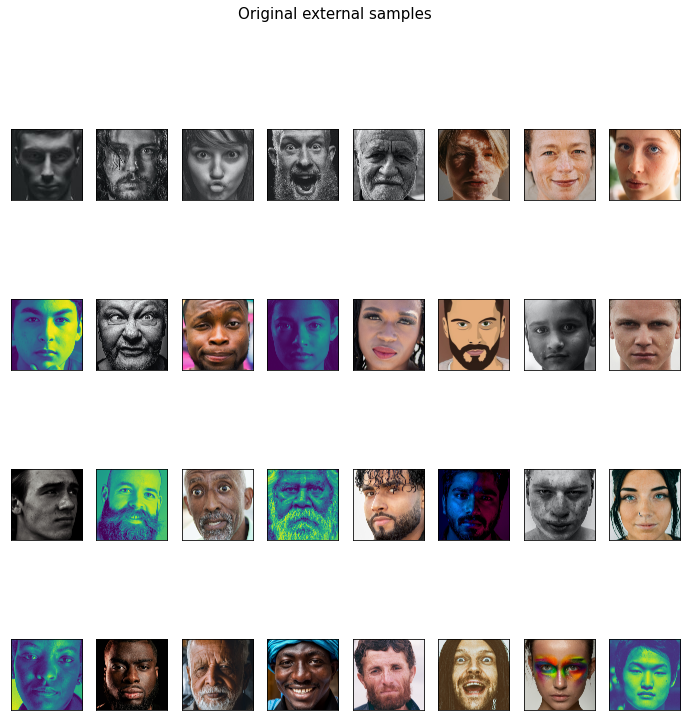

In [41]:
from PIL import Image
import os

fig = plt.figure(figsize = (12,12))
fig.suptitle('Original external samples', fontsize=15)

image_number = 1
for im in os.listdir('ProcessedImages')[1:]:
    image = Image.open('ProcessedImages/'+str(im))
    fig.add_subplot(4,8, image_number, xticks=[], yticks=[])
    image_number+=1
    plt.imshow(image)
plt.show()


#### Formated Images

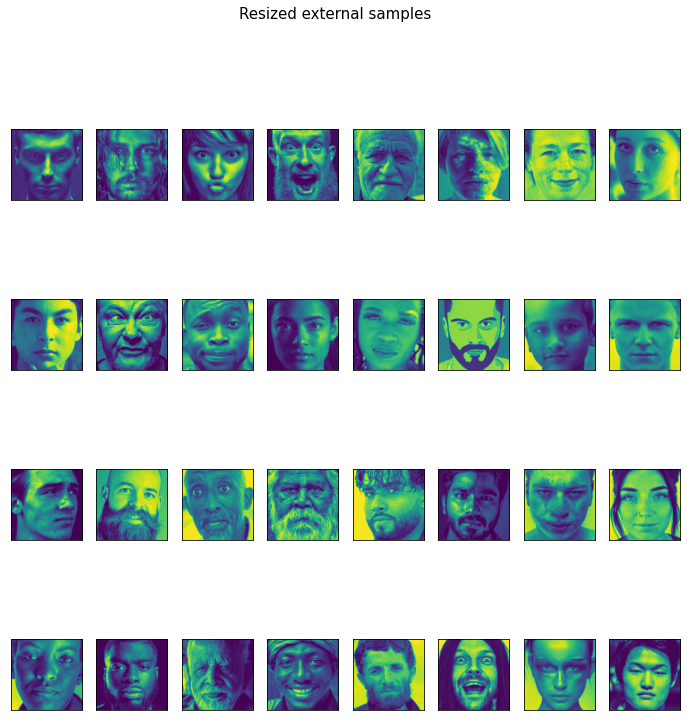

In [69]:
external_samples = []
image_number = 1
fig = plt.figure(figsize = (12,12))
fig.suptitle('Resized external samples', fontsize=15)

for im in os.listdir('ProcessedImages')[1:]:
    img = cv2.imread('ProcessedImages/'+str(im), cv2.IMREAD_UNCHANGED)
    # Turn non-grayscale images into grayscale
    if img.ndim==3:
        grayImage = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    else:
        grayImage = img
    dim = (96, 96)
    resized = cv2.resize(grayImage, dim, interpolation = cv2.INTER_AREA)
    pixel_values = np.reshape(resized, (96, 96, 1))
    
    external_samples.append(pixel_values)
    #pixel_values /=255
    fig.add_subplot(4,8, image_number, xticks=[], yticks=[])
    image_number+=1
    plt.imshow(pixel_values)
    plt.imshow(pixel_values)
plt.show()

external_samples = np.array(external_samples, dtype='float')
external_samples /= 255

#### Predict Keypoints for External Emages

In [71]:
external_predict =  model.predict(external_samples)

1/1 [==============================] - 0s 132ms/step


#### Vizualize predictions

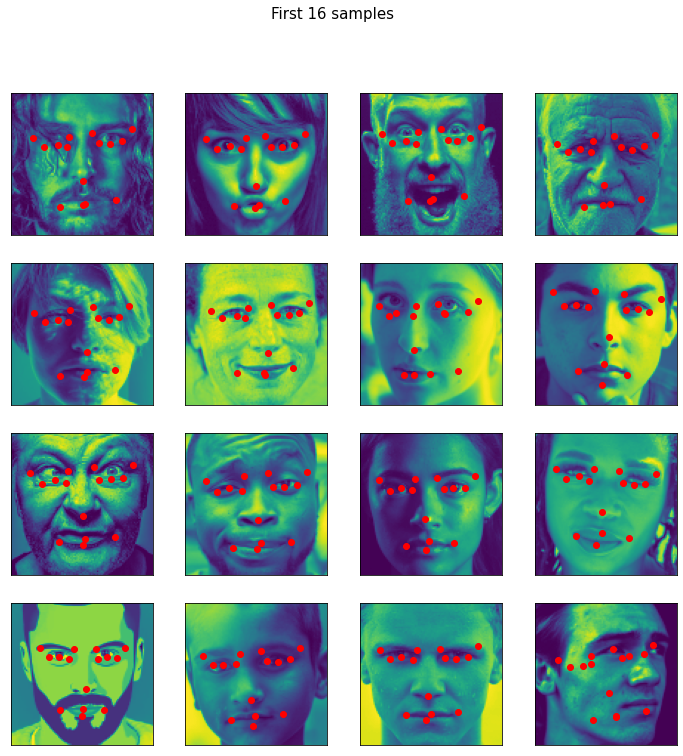

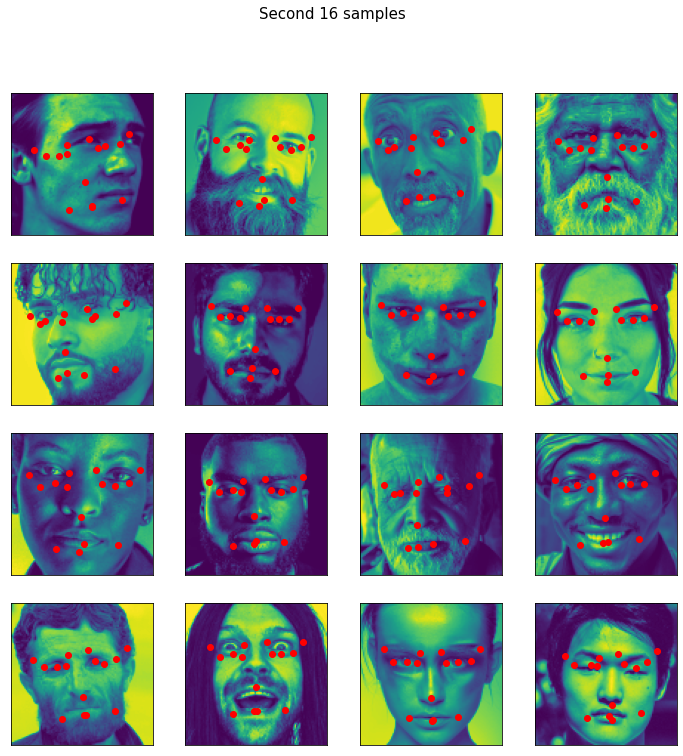

In [84]:
fig_first = plt.figure(figsize = (12,12))
fig_first.suptitle('First 16 samples', fontsize=15)

for j in range (16):
    fig_first.add_subplot(4,4,j+1, xticks=[], yticks=[])
    plot_keypoints(external_samples, external_predict, j+1)
plt.show()

fig_second = plt.figure(figsize = (12,12))
fig_second.suptitle('Second 16 samples', fontsize=15)

for i in range (16,32):
    fig_second.add_subplot(4,4,i-15, xticks=[], yticks=[])
    plot_keypoints(external_samples, external_predict, i)
plt.show()


Images from an external source have more variation than the training set. It can be seen that the model was not able to cope with all scenarios. Strong grimaces and images at an angle are the most confusing. Interestingly, the model successfully hit the keypoints on the cartoon character.

## Conclusion

It can be said that the convolutional model is well trained to detect keypoints based on the training set. The images from the test set were formatted in the same way and the network was able to localize the keypoints with high accuracy. On the other hand, images from external sources have had mixed success. Keypoints for images where the entire face is directly visible are successfully detected. The performance of the model decreases with each exit from the training ground. Strong grimaces, a lot of hair and beard, makeup, as well as pictures of faces at an angle confused the model.
It can be said that the model is successfully trained for images where the face is clearly and directly visible, but for other scenarios, the training set needs to be expanded.